In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
x_train = mnist.train.images
y_train = mnist.train.labels
x_test = mnist.test.images
y_test = mnist.test.labels
batch_size = 256
g_dim = 100

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding = 'SAME')
def deconv2d(x, W, output_shape):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, 2, 2, 1], padding = 'SAME')

class layer:
    def __init__(self, in_size, out_size):
#         self.W = tf.Variable(tf.zeros([in_size, out_size]))
        self.W = tf.Variable(tf.random_normal([in_size, out_size], mean=0.0, stddev=0.01))
#         self.b = tf.Variable(tf.zeros([1,out_size]))
#         self.b = tf.Variable(tf.constant(0.1, shape=[1,out_size]))
        self.b = tf.Variable(tf.random_normal([1, out_size], mean=0.0, stddev=0.01))
    
        
    def output(self, inputs, activation_function=None):
        if activation_function == None:
            return tf.matmul(inputs, self.W) + self.b
        else :
            return activation_function(tf.matmul(inputs, self.W) + self.b)
        
def weight_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.01)
    return tf.Variable(initial)

# def max_unpool_2x2(x, output_shape):
#     out = tf.concat([x, tf.zeros_like(x)], 3)
#     out = tf.concat([out, tf.zeros_like(out)], 2)
#     out_size = output_shape
#     return tf.reshape(out, out_size)

# def max_pool_2x2(x):
#     _, argmax = tf.nn.max_pool_with_argmax(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
#     pool = tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
#     return pool, argmax

In [4]:
weights = {
#     "w_d1" : weight_variable([5, 5, 1, 32]),
#     "w_d2" : weight_variable([5, 5, 32, 64]),
#     "w_d3" : weight_variable([7 * 7 * 64, 1]),
    
    "W_e_conv1" : weight_variable([5,5,1,16]),
    "W_e_conv2" : weight_variable([5,5,16,32]),
    "W_d_conv1" : weight_variable([5,5,16,32]),
    "W_d_conv2" : weight_variable([5, 5, 1, 16]),
    
    "w_g1" : weight_variable([g_dim, 4 * 4 * 64]),
    "w_g2" : weight_variable([5, 5, 32, 64]),
    "w_g3" : weight_variable([5, 5, 16, 32]),
    "w_g4" : weight_variable([5, 5, 1, 16])
}

biases = {
#     "b_d1" : bias_variable([32]),
#     "b_d2" : bias_variable([64]),
#     "b_d3" : bias_variable([1]),
    "b_e_conv1" : bias_variable([16]),   
    "b_e_conv2" : bias_variable([32]),
    "b_d_conv1" : bias_variable([16]),
    "b_d_conv2" : bias_variable([1]),
    
    "b_g1" : bias_variable([4 * 4 * 64]),
    "b_g2" : bias_variable([32]),
    "b_g3" : bias_variable([16]),
    "b_g4" : bias_variable([1]),
}


var_d = [weights["W_e_conv1"], weights["W_e_conv2"], weights["W_d_conv1"], weights["W_d_conv2"], biases["b_e_conv1"], biases["b_e_conv2"], biases["b_d_conv1"], biases["b_d_conv2"]]
var_g = [weights["w_g1"], weights["w_g2"],weights["w_g3"], weights["w_g4"], biases["b_g1"], biases["b_g2"],biases["b_g3"], biases["b_g4"]]

In [5]:
def generator(z):
    #100 x 1
    h_g1 = tf.nn.relu(tf.add(tf.matmul(z, weights["w_g1"]), biases["b_g1"]))
    #-1 x 4*4*128
    h_g1_reshape = tf.reshape(h_g1, [-1, 4, 4, 64])
    
    output_shape_g2 = tf.stack([tf.shape(z)[0], 7, 7, 32])
    h_g2 = tf.nn.relu(tf.add(deconv2d(h_g1_reshape, weights["w_g2"], output_shape_g2), biases["b_g2"]))
    
    output_shape_g3 = tf.stack([tf.shape(z)[0], 14, 14, 16])
    h_g3 = tf.nn.relu(tf.add(deconv2d(h_g2, weights["w_g3"], output_shape_g3), biases["b_g3"]))
    
    output_shape_g4 = tf.stack([tf.shape(z)[0], 28, 28, 1])
    h_g4 = tf.nn.tanh(tf.add(deconv2d(h_g3, weights["w_g4"], output_shape_g4), biases["b_g4"]))
    
    return h_g4


# def discriminator(x):
#     x_reshape = tf.reshape(x, [-1, 28, 28, 1])
#     # 28 x 28 x 1
#     h_d1 = tf.nn.relu(tf.add(conv2d(x_reshape, weights["w_d1"]), biases["b_d1"]))
#     # 14 x 14 x 32
#     h_d2 = tf.nn.relu(tf.add(conv2d(h_d1, weights["w_d2"]), biases["b_d2"]))
#     # 7 x 7 x 64
#     h_d2_reshape = tf.reshape(h_d2, [-1, 7 * 7 * 64])
#     h_d3 = tf.nn.sigmoid(tf.add(tf.matmul(h_d2_reshape, weights["w_d3"]), biases["b_d3"]))
#     return h_d3

def discriminator(x):
    x_origin = tf.reshape(x, [-1,28,28,1])
#     x_origin = x
    
    h_e_conv1 = tf.nn.relu(tf.add(conv2d(x_origin, weights["W_e_conv1"]), biases["b_e_conv1"]))

    h_e_conv2 = tf.nn.relu(tf.add(conv2d(h_e_conv1, weights["W_e_conv2"]), biases["b_e_conv2"]))

    output_shape_d_conv1 = tf.stack([tf.shape(x)[0], 14, 14, 16])
    h_d_conv1 = tf.nn.relu(deconv2d(h_e_conv2, weights["W_d_conv1"], output_shape_d_conv1)+biases["b_d_conv1"])

    output_shape_d_conv2 = tf.stack([tf.shape(x)[0], 28, 28, 1])
    h_d_conv2 = tf.nn.relu(deconv2d(h_d_conv1, weights["W_d_conv2"], output_shape_d_conv2)+biases["b_d_conv2"])

    return h_d_conv2


In [12]:
x_d = tf.placeholder(tf.float32, shape = [None, 784])
x_g = tf.placeholder(tf.float32, shape = [None, g_dim])

def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

def loss(x):
#     return tf.reduce_mean(tf.abs(tf.reshape(x, [-1,28,28,1])-discriminator(x)))
#     return tf.sqrt(tf.reduce_mean(tf.pow(tf.reshape(x, [-1,28,28,1])-discriminator(x), 2)))
#     return tf.reduce_mean(tf.pow(tf.reshape(x, [-1,28,28,1])-discriminator(x), 2))
#     return tf.reduce_mean(tf.pow(tf.reshape(x, [-1, 784]) - tf.reshape(discriminator(x), [-1, 784]), 2))
    return tf.pow(tf.reshape(x, [-1, 784]) - tf.reshape(discriminator(x), [-1, 784]), 2)
#     return tf.pow(x-discriminator(x), 2)

# def gamma(x,z):
# #     return loss(generator(z))/loss(x)
#     return 0.5
gamma = 0.5

k_t = 0
# k_t = tf.Variable(0.0)


In [13]:
# g_sample = generator(x_g)
# d_real = discriminator(x_d)
# d_fake = discriminator(g_sample)

# d_loss = tf.reduce_mean(loss(x_d)-k_t*loss(generator(x_g)))
d_loss = tf.reduce_mean(loss(x_d))
g_loss = tf.reduce_mean(loss(generator(x_g)))

g_sample = generator(x_g)

M_global = tf.reduce_mean(loss(x_d) + tf.abs(gamma*loss(x_d) - loss(generator(x_g))))

# d_loss = -tf.reduce_mean(tf.log(d_real) + tf.log(1. - d_fake))
# g_loss = -tf.reduce_mean(tf.log(d_fake))

In [14]:
# 只更新 discriminator
d_optimizer = tf.train.AdamOptimizer(0.00001).minimize(d_loss, var_list= var_d)
# d_optimizer = tf.train.MomentumOptimizer(0.01,0.01).minimize(d_loss, var_list= var_d)
# 只更新 generator parameters
g_optimizer = tf.train.AdamOptimizer(0.00001).minimize(g_loss, var_list= var_g)
# g_optimizer = tf.train.MomentumOptimizer(0.01,0.01).minimize(g_loss, var_list= var_g)

# balancer = gamma(x_d, x_g)*loss(x_d) - loss(generator(x_g))
balancer = gamma*loss(x_d) - loss(generator(x_g))

In [15]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for step in range(10001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     print batch_x.shape
#     print batch_size
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
#     k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)}))
#     k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)}))
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train

        
zz = sample_Z(batch_size, g_dim)
# gg = sess.run(g_sample, feed_dict = {x_g: zz})
gg = sess.run(g_sample, feed_dict = {x_g: x_train})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 0.108568  g-loss: 0.000283926 k_t: 0 M_global: 0.162917
step: 1000  d-loss: 0.06223  g-loss: 0.00063704 k_t: 0 M_global: 0.0927344
step: 2000  d-loss: 0.0405246  g-loss: 6.27194e-05 k_t: 0 M_global: 0.0608091
step: 3000  d-loss: 0.0282721  g-loss: 4.53925e-06 k_t: 0 M_global: 0.0424097
step: 4000  d-loss: 0.0220688  g-loss: 6.04814e-07 k_t: 0 M_global: 0.0331035
step: 5000  d-loss: 0.0150977  g-loss: 2.40476e-07 k_t: 0 M_global: 0.0226466
step: 6000  d-loss: 0.0120546  g-loss: 1.38768e-07 k_t: 0 M_global: 0.018082
step: 7000  d-loss: 0.0101661  g-loss: 8.86306e-08 k_t: 0 M_global: 0.0152492
step: 8000  d-loss: 0.00806488  g-loss: 5.7233e-08 k_t: 0 M_global: 0.0120974
step: 9000  d-loss: 0.00726453  g-loss: 3.80514e-08 k_t: 0 M_global: 0.0108968
step: 10000  d-loss: 0.00665416  g-loss: 2.52785e-08 k_t: 0 M_global: 0.00998125


ValueError: Cannot feed value of shape (55000, 784) for Tensor u'Placeholder_3:0', which has shape '(?, 100)'

In [10]:
for step in range(10001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     print batch_x.shape
#     print batch_size
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
#     k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)}))
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train

        
zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 0.00627189  g-loss: 6.44498e-08 k_t: [[ -9.36646427e-10  -2.12404233e-10  -1.44214697e-12 ...,  -1.24619221e-11
   -4.32140608e-12  -2.99130720e-10]
 [ -2.43968667e-09  -1.17573928e-09  -3.48753387e-10 ...,  -1.05486973e-10
   -1.60441400e-11  -3.60443647e-10]
 [ -2.12844897e-09  -1.00628095e-09  -3.05974551e-10 ...,  -2.35072812e-11
   -2.68624879e-12  -2.11720599e-10]
 ..., 
 [ -2.61698152e-09  -1.14122556e-09  -3.04829911e-10 ...,  -2.90785156e-11
   -5.08146043e-12  -3.16956739e-10]
 [ -2.28464625e-09  -1.03139308e-09  -3.06145637e-10 ...,  -1.67455924e-10
   -3.40078313e-11  -6.19544915e-10]
 [ -2.14742624e-09  -7.99082023e-10  -1.94854785e-10 ...,  -9.60596078e-13
   -2.13167348e-11  -1.66915967e-10]] M_global: 0.00940788
step: 1000  d-loss: 0.00543013  g-loss: 4.55464e-08 k_t: [[ -1.38191035e-06  -5.46173396e-07  -1.36107005e-07 ...,  -3.68587543e-08
   -1.89915426e-08  -1.59516830e-07]
 [ -1.38599455e-06  -5.53296672e-07  -1.39025417e-07 ...,  -3.97534095e-08
 

KeyboardInterrupt: 

step: 0  d-loss: 0.00260316  g-loss: 4.45422e-09 k_t: -1.48071440444 M_global: 0.00390473
step: 1000  d-loss: 0.00239716  g-loss: 3.41079e-09 k_t: -1.47945068321 M_global: 0.00359575
step: 2000  d-loss: 0.0022474  g-loss: 2.61508e-09 k_t: -1.47827170131 M_global: 0.0033711
step: 3000  d-loss: 0.00218734  g-loss: 2.06669e-09 k_t: -1.47716637136 M_global: 0.003281
step: 4000  d-loss: 0.00203919  g-loss: 1.622e-09 k_t: -1.47612540054 M_global: 0.00305879
step: 5000  d-loss: 0.00192056  g-loss: 1.31447e-09 k_t: -1.47514207165 M_global: 0.00288083
step: 6000  d-loss: 0.00191628  g-loss: 1.05875e-09 k_t: -1.4742086546 M_global: 0.00287442
step: 7000  d-loss: 0.00174761  g-loss: 8.70216e-10 k_t: -1.47331975924 M_global: 0.00262141
step: 8000  d-loss: 0.00165952  g-loss: 7.38967e-10 k_t: -1.47247036213 M_global: 0.00248928
step: 9000  d-loss: 0.00155756  g-loss: 6.32929e-10 k_t: -1.47165720756 M_global: 0.00233634
step: 10000  d-loss: 0.00158154  g-loss: 5.22156e-10 k_t: -1.47087662394 M_globa

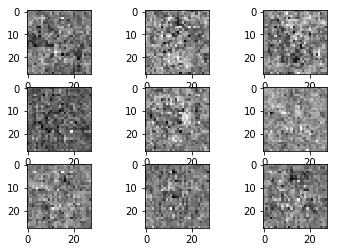

In [125]:
for step in range(10001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     print batch_x.shape
#     print batch_size
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)}))
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train

        
zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 0.00151797  g-loss: 5.22584e-10 k_t: -1.47087586495 M_global: 0.00227696
step: 1000  d-loss: 0.00148489  g-loss: 4.44919e-10 k_t: -1.47012514294 M_global: 0.00222734
step: 2000  d-loss: 0.00141631  g-loss: 3.89137e-10 k_t: -1.46940199212 M_global: 0.00212446
step: 3000  d-loss: 0.00137766  g-loss: 3.34777e-10 k_t: -1.4687044106 M_global: 0.00206649
step: 4000  d-loss: 0.0013382  g-loss: 2.93028e-10 k_t: -1.46803007802 M_global: 0.0020073
step: 5000  d-loss: 0.00126565  g-loss: 2.58512e-10 k_t: -1.46737855609 M_global: 0.00189847
step: 6000  d-loss: 0.00128591  g-loss: 2.27135e-10 k_t: -1.46674726485 M_global: 0.00192886
step: 7000  d-loss: 0.0011935  g-loss: 2.0067e-10 k_t: -1.46613548941 M_global: 0.00179025
step: 8000  d-loss: 0.00115324  g-loss: 1.77731e-10 k_t: -1.46554185409 M_global: 0.00172985
step: 9000  d-loss: 0.00114304  g-loss: 1.57575e-10 k_t: -1.46496544906 M_global: 0.00171456
step: 10000  d-loss: 0.00109018  g-loss: 1.3881e-10 k_t: -1.46440541429 M_glob

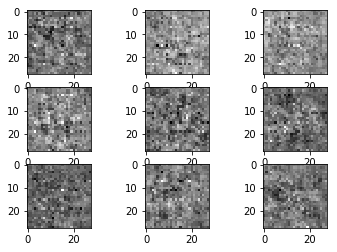

In [126]:
for step in range(10001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     print batch_x.shape
#     print batch_size
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)}))
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train

        
zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 0.00115178  g-loss: 1.40552e-10 k_t: -1.4644048384 M_global: 0.00172767
step: 1000  d-loss: 0.00104613  g-loss: 1.26278e-10 k_t: -1.46386028349 M_global: 0.00156919
step: 2000  d-loss: 0.0010147  g-loss: 1.1296e-10 k_t: -1.46333097607 M_global: 0.00152205
step: 3000  d-loss: 0.000994322  g-loss: 1.01376e-10 k_t: -1.46281615345 M_global: 0.00149148
step: 4000  d-loss: 0.00096845  g-loss: 9.12888e-11 k_t: -1.4623152505 M_global: 0.00145268
step: 5000  d-loss: 0.000935454  g-loss: 8.25116e-11 k_t: -1.46182823747 M_global: 0.00140318
step: 6000  d-loss: 0.000913204  g-loss: 7.41767e-11 k_t: -1.46135467455 M_global: 0.00136981
step: 7000  d-loss: 0.000910438  g-loss: 6.84666e-11 k_t: -1.46089464541 M_global: 0.00136566
step: 8000  d-loss: 0.000879502  g-loss: 6.1219e-11 k_t: -1.46044744757 M_global: 0.00131925
step: 9000  d-loss: 0.000866278  g-loss: 5.70553e-11 k_t: -1.46001299432 M_global: 0.00129942
step: 10000  d-loss: 0.000851636  g-loss: 5.08551e-11 k_t: -1.4595909224

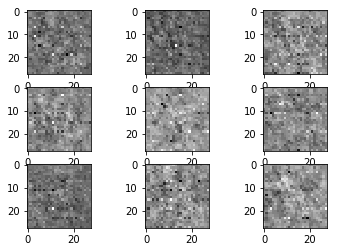

In [127]:
for step in range(10001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     print batch_x.shape
#     print batch_size
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)}))
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train

        
zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 0.000819334  g-loss: 5.11253e-11 k_t: -1.45959051277 M_global: 0.001229
step: 1000  d-loss: 0.000808283  g-loss: 4.69992e-11 k_t: -1.45918029533 M_global: 0.00121242
step: 2000  d-loss: 0.00081259  g-loss: 4.21313e-11 k_t: -1.45878216569 M_global: 0.00121888
step: 3000  d-loss: 0.000768461  g-loss: 3.99924e-11 k_t: -1.45839570362 M_global: 0.00115269
step: 4000  d-loss: 0.000721726  g-loss: 3.57514e-11 k_t: -1.45802093763 M_global: 0.00108259
step: 5000  d-loss: 0.000732312  g-loss: 3.27013e-11 k_t: -1.45765716423 M_global: 0.00109847
step: 6000  d-loss: 0.000700703  g-loss: 2.98968e-11 k_t: -1.45730469851 M_global: 0.00105105
step: 7000  d-loss: 0.000680759  g-loss: 2.79952e-11 k_t: -1.45696304407 M_global: 0.00102114
step: 8000  d-loss: 0.000644652  g-loss: 2.55334e-11 k_t: -1.45663194656 M_global: 0.000966977
step: 9000  d-loss: 0.000638003  g-loss: 2.39336e-11 k_t: -1.4563112809 M_global: 0.000957004
step: 10000  d-loss: 0.000610186  g-loss: 2.23857e-11 k_t: -1.456

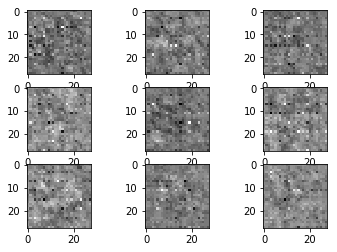

In [128]:
for step in range(10001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     print batch_x.shape
#     print batch_size
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)}))
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train

        
zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 0.00058793  g-loss: 2.29422e-11 k_t: -1.45600049356 M_global: 0.000881895
step: 1000  d-loss: 0.000587504  g-loss: 2.03683e-11 k_t: -1.45569979591 M_global: 0.000881256
step: 2000  d-loss: 0.00056806  g-loss: 1.84249e-11 k_t: -1.4554090089 M_global: 0.00085209
step: 3000  d-loss: 0.000539183  g-loss: 1.76934e-11 k_t: -1.45512754153 M_global: 0.000808775
step: 4000  d-loss: 0.000546309  g-loss: 1.55757e-11 k_t: -1.45485552891 M_global: 0.000819463
step: 5000  d-loss: 0.000503215  g-loss: 1.48511e-11 k_t: -1.45459267256 M_global: 0.000754823
step: 6000  d-loss: 0.000506866  g-loss: 1.43704e-11 k_t: -1.45433871396 M_global: 0.000760299
step: 7000  d-loss: 0.000487684  g-loss: 1.3138e-11 k_t: -1.45409359776 M_global: 0.000731526
step: 8000  d-loss: 0.000468103  g-loss: 1.19384e-11 k_t: -1.45385677848 M_global: 0.000702155
step: 9000  d-loss: 0.000475803  g-loss: 1.10918e-11 k_t: -1.45362825365 M_global: 0.000713704
step: 10000  d-loss: 0.000434209  g-loss: 1.05631e-11 k_t:

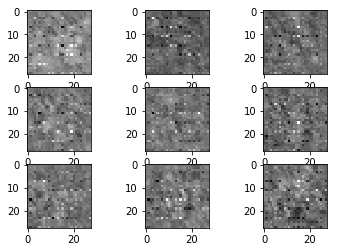

In [129]:
for step in range(10001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     print batch_x.shape
#     print batch_size
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)}))
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train

        
zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 0.000431906  g-loss: 1.08162e-11 k_t: -1.45340740601 M_global: 0.00064786
step: 1000  d-loss: 0.000426102  g-loss: 9.46809e-12 k_t: -1.45319464158 M_global: 0.000639153
step: 2000  d-loss: 0.000400083  g-loss: 8.89877e-12 k_t: -1.45298938293 M_global: 0.000600124
step: 3000  d-loss: 0.000371036  g-loss: 8.2721e-12 k_t: -1.45279137984 M_global: 0.000556553
step: 4000  d-loss: 0.000389775  g-loss: 8.02988e-12 k_t: -1.45260048718 M_global: 0.000584662
step: 5000  d-loss: 0.000368635  g-loss: 7.57379e-12 k_t: -1.45241653225 M_global: 0.000552952
step: 6000  d-loss: 0.000336875  g-loss: 6.81068e-12 k_t: -1.4522392316 M_global: 0.000505313
step: 7000  d-loss: 0.00033628  g-loss: 6.64062e-12 k_t: -1.45206833521 M_global: 0.000504419
step: 8000  d-loss: 0.000306814  g-loss: 5.81838e-12 k_t: -1.45190381679 M_global: 0.000460221
step: 9000  d-loss: 0.000296468  g-loss: 5.73299e-12 k_t: -1.45174532493 M_global: 0.000444702
step: 10000  d-loss: 0.000306122  g-loss: 5.23893e-12 k_t

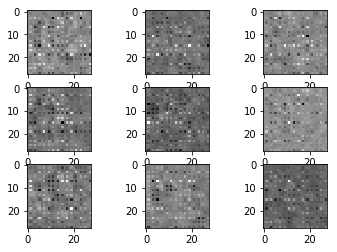

In [130]:
for step in range(50001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     print batch_x.shape
#     print batch_size
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)}))
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train

        
zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 3.76335e-05  g-loss: 4.1191e-13 k_t: -1.44872353085 M_global: 5.64503e-05
step: 1000  d-loss: 3.24576e-05  g-loss: 6.47618e-13 k_t: -1.44870559679 M_global: 4.86864e-05
step: 2000  d-loss: 3.09226e-05  g-loss: 4.63209e-13 k_t: -1.44868914819 M_global: 4.63838e-05
step: 3000  d-loss: 2.67259e-05  g-loss: 3.54519e-13 k_t: -1.44867412517 M_global: 4.00889e-05
step: 4000  d-loss: 2.64661e-05  g-loss: 4.01554e-13 k_t: -1.44866044783 M_global: 3.96991e-05
step: 5000  d-loss: 2.37486e-05  g-loss: 3.30215e-13 k_t: -1.44864799321 M_global: 3.56228e-05
step: 6000  d-loss: 2.0497e-05  g-loss: 2.8821e-13 k_t: -1.44863670723 M_global: 3.07455e-05
step: 7000  d-loss: 1.65967e-05  g-loss: 1.21462e-12 k_t: -1.44862647945 M_global: 2.48951e-05
step: 8000  d-loss: 1.65175e-05  g-loss: 1.12654e-12 k_t: -1.44861720067 M_global: 2.47763e-05
step: 9000  d-loss: 1.44954e-05  g-loss: 2.71396e-13 k_t: -1.44860878092 M_global: 2.17431e-05
step: 10000  d-loss: 1.72432e-05  g-loss: 2.98325e-13 k_

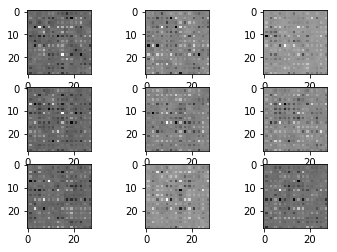

In [131]:
for step in range(50001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     print batch_x.shape
#     print batch_size
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)}))
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train

        
zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 3.59713e-06  g-loss: 2.25008e-14 k_t: -1.44846984312 M_global: 5.39569e-06
step: 1000  d-loss: 4.79189e-06  g-loss: 2.23283e-14 k_t: -1.44846784148 M_global: 7.18783e-06
step: 2000  d-loss: 3.042e-06  g-loss: 2.6644e-14 k_t: -1.44846586814 M_global: 4.56301e-06
step: 3000  d-loss: 2.65024e-06  g-loss: 5.11332e-13 k_t: -1.44846391402 M_global: 3.97536e-06
step: 4000  d-loss: 3.86308e-06  g-loss: 2.35502e-12 k_t: -1.44846199218 M_global: 5.79461e-06
step: 5000  d-loss: 6.76198e-06  g-loss: 2.70511e-14 k_t: -1.4484600873 M_global: 1.0143e-05
step: 6000  d-loss: 3.28327e-06  g-loss: 1.61248e-14 k_t: -1.44845820532 M_global: 4.9249e-06
step: 7000  d-loss: 3.8613e-06  g-loss: 9.06845e-14 k_t: -1.44845633778 M_global: 5.79196e-06
step: 8000  d-loss: 2.25004e-06  g-loss: 3.12517e-14 k_t: -1.44845449269 M_global: 3.37506e-06
step: 9000  d-loss: 2.99966e-06  g-loss: 4.42105e-14 k_t: -1.44845267431 M_global: 4.49949e-06
step: 10000  d-loss: 7.50003e-06  g-loss: 1.76814e-13 k_t: -

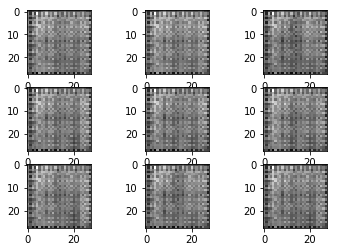

In [132]:
for step in range(50001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     print batch_x.shape
#     print batch_size
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)}))
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train

        
zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 0.100619  g-loss: 1.67752e-05 k_t: -390.730528181 M_global: 0.150933
step: 1000  d-loss: 0.0970202  g-loss: 1.01905e-05 k_t: -390.681470223 M_global: 0.145533
step: 2000  d-loss: 0.0992683  g-loss: 7.03653e-06 k_t: -390.632404717 M_global: 0.148904
step: 3000  d-loss: 0.0947186  g-loss: 4.68821e-06 k_t: -390.583364426 M_global: 0.142079
step: 4000  d-loss: 0.0955277  g-loss: 4.11392e-06 k_t: -390.534313318 M_global: 0.143293
step: 5000  d-loss: 0.0985352  g-loss: 3.0698e-06 k_t: -390.485293978 M_global: 0.147804
step: 6000  d-loss: 0.101204  g-loss: 2.4911e-06 k_t: -390.436256927 M_global: 0.151807
step: 7000  d-loss: 0.0988519  g-loss: 2.23849e-06 k_t: -390.387229073 M_global: 0.148278
step: 8000  d-loss: 0.0995546  g-loss: 1.71618e-06 k_t: -390.338204875 M_global: 0.149332
step: 9000  d-loss: 0.0999939  g-loss: 1.81713e-06 k_t: -390.289182972 M_global: 0.149991
step: 10000  d-loss: 0.0989035  g-loss: 2.15047e-06 k_t: -390.240162417 M_global: 0.148356
step: 11000  d-l

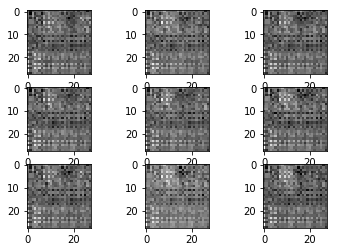

In [133]:
for step in range(50001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     print batch_x.shape
#     print batch_size
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)}))
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train

        
zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 0.0881071  g-loss: 6.73431e-08 k_t: -388.332171085 M_global: 0.132161
step: 1000  d-loss: 0.0923424  g-loss: 4.89808e-08 k_t: -388.28666292 M_global: 0.138514
step: 2000  d-loss: 0.0896605  g-loss: 3.65967e-08 k_t: -388.241154507 M_global: 0.134491
step: 3000  d-loss: 0.0899094  g-loss: 2.69998e-08 k_t: -388.195663867 M_global: 0.134864
step: 4000  d-loss: 0.0927438  g-loss: 1.9687e-08 k_t: -388.150178159 M_global: 0.139116
step: 5000  d-loss: 0.0912918  g-loss: 1.41896e-08 k_t: -388.104666843 M_global: 0.136938
step: 6000  d-loss: 0.0903599  g-loss: 9.95809e-09 k_t: -388.059174265 M_global: 0.13554
step: 7000  d-loss: 0.0898716  g-loss: 7.11574e-09 k_t: -388.013683938 M_global: 0.134807
step: 8000  d-loss: 0.0911947  g-loss: 5.2776e-09 k_t: -387.968176719 M_global: 0.136792
step: 9000  d-loss: 0.091428  g-loss: 3.94283e-09 k_t: -387.922677917 M_global: 0.137142
step: 10000  d-loss: 0.0900931  g-loss: 3.09037e-09 k_t: -387.877197751 M_global: 0.13514
step: 11000  d-los

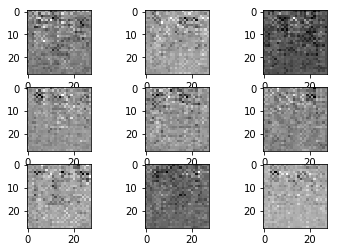

In [134]:
for step in range(50001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     print batch_x.shape
#     print batch_size
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)}))
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train

        
zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 0.0891409  g-loss: 3.69783e-11 k_t: -386.05743679 M_global: 0.133711
step: 1000  d-loss: 0.0918136  g-loss: 3.41392e-11 k_t: -386.011948413 M_global: 0.13772
step: 2000  d-loss: 0.0955646  g-loss: 3.26226e-11 k_t: -385.966442534 M_global: 0.143347
step: 3000  d-loss: 0.0914723  g-loss: 3.02239e-11 k_t: -385.920944931 M_global: 0.137208
step: 4000  d-loss: 0.0920773  g-loss: 2.99239e-11 k_t: -385.875462077 M_global: 0.138116
step: 5000  d-loss: 0.0935668  g-loss: 2.7393e-11 k_t: -385.829968166 M_global: 0.14035
step: 6000  d-loss: 0.090456  g-loss: 2.69106e-11 k_t: -385.784484613 M_global: 0.135684
step: 7000  d-loss: 0.0911044  g-loss: 2.54571e-11 k_t: -385.738984259 M_global: 0.136657
step: 8000  d-loss: 0.0913917  g-loss: 2.45027e-11 k_t: -385.693516068 M_global: 0.137087
step: 9000  d-loss: 0.0918881  g-loss: 2.25353e-11 k_t: -385.648005341 M_global: 0.137832
step: 10000  d-loss: 0.08845  g-loss: 2.16093e-11 k_t: -385.602518879 M_global: 0.132675
step: 11000  d-loss

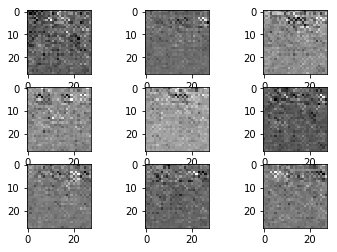

In [135]:
for step in range(50001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     print batch_x.shape
#     print batch_size
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)}))
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train

        
zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 0.0932638  g-loss: 4.80463e-12 k_t: -383.782810726 M_global: 0.139896
step: 1000  d-loss: 0.0903575  g-loss: 4.48298e-12 k_t: -383.737316536 M_global: 0.135536
step: 2000  d-loss: 0.0888182  g-loss: 4.36063e-12 k_t: -383.691821731 M_global: 0.133227
step: 3000  d-loss: 0.0910496  g-loss: 4.35264e-12 k_t: -383.646333279 M_global: 0.136574
step: 4000  d-loss: 0.090372  g-loss: 4.30423e-12 k_t: -383.600830016 M_global: 0.135558
step: 5000  d-loss: 0.0913322  g-loss: 3.97535e-12 k_t: -383.555344546 M_global: 0.136998
step: 6000  d-loss: 0.0922512  g-loss: 4.07196e-12 k_t: -383.509861859 M_global: 0.138377
step: 7000  d-loss: 0.0911137  g-loss: 3.75925e-12 k_t: -383.464361565 M_global: 0.136671
step: 8000  d-loss: 0.0873668  g-loss: 3.71412e-12 k_t: -383.418884482 M_global: 0.13105
step: 9000  d-loss: 0.0895767  g-loss: 3.58668e-12 k_t: -383.373378311 M_global: 0.134365
step: 10000  d-loss: 0.0889081  g-loss: 3.95042e-12 k_t: -383.327882826 M_global: 0.133362
step: 11000  d

step: 92000  d-loss: 0.114515  g-loss: 0.000521504 k_t: -2833.89340366 M_global: 0.171918
step: 93000  d-loss: 0.112643  g-loss: 0.00027301 k_t: -2833.83777683 M_global: 0.169041
step: 94000  d-loss: 0.112077  g-loss: 0.000136569 k_t: -2833.78195653 M_global: 0.168154
step: 95000  d-loss: 0.11355  g-loss: 6.11916e-05 k_t: -2833.72602202 M_global: 0.170343
step: 96000  d-loss: 0.111404  g-loss: 2.41502e-05 k_t: -2833.67004964 M_global: 0.167113
step: 97000  d-loss: 0.114322  g-loss: 7.99277e-06 k_t: -2833.61403094 M_global: 0.171486
step: 98000  d-loss: 0.116683  g-loss: 0.00190551 k_t: -2833.55340128 M_global: 0.175556
step: 99000  d-loss: 0.110807  g-loss: 0.00165844 k_t: -2833.49874148 M_global: 0.166674
step: 100000  d-loss: 0.112464  g-loss: 0.00135917 k_t: -2833.44414368 M_global: 0.169076


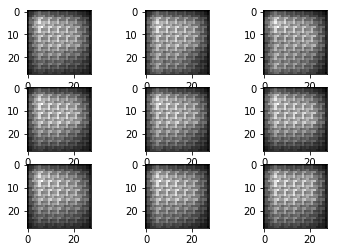

In [136]:
for step in range(100001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     print batch_x.shape
#     print batch_size
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)}))
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train

        
zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 0.10918  g-loss: 0.00135728 k_t: -2833.44408987 M_global: 0.164149
step: 1000  d-loss: 0.10775  g-loss: 0.00104977 k_t: -2833.38923237 M_global: 0.161918
step: 2000  d-loss: 0.110119  g-loss: 0.000762153 k_t: -2833.3340925 M_global: 0.165392
step: 3000  d-loss: 0.111821  g-loss: 0.000517993 k_t: -2833.27871209 M_global: 0.167876
step: 4000  d-loss: 0.112814  g-loss: 0.000331725 k_t: -2833.22310792 M_global: 0.169314
step: 5000  d-loss: 0.110791  g-loss: 0.000204295 k_t: -2833.16733472 M_global: 0.166244
step: 6000  d-loss: 0.112738  g-loss: 0.000117197 k_t: -2833.11145446 M_global: 0.169139
step: 7000  d-loss: 0.111058  g-loss: 6.26225e-05 k_t: -2833.05552876 M_global: 0.166604
step: 8000  d-loss: 0.110524  g-loss: 5.11481e-06 k_t: -2832.99955716 M_global: 0.165788
step: 9000  d-loss: 0.111878  g-loss: 0.000700921 k_t: -2832.94362549 M_global: 0.168013
step: 10000  d-loss: 0.110417  g-loss: 0.000200099 k_t: -2832.88795253 M_global: 0.165681
step: 11000  d-loss: 0.11370

step: 92000  d-loss: 0.110604  g-loss: 2.3061e-10 k_t: -2828.29452438 M_global: 0.165906
step: 93000  d-loss: 0.110682  g-loss: 2.2102e-10 k_t: -2828.23850672 M_global: 0.166023
step: 94000  d-loss: 0.109112  g-loss: 2.13576e-10 k_t: -2828.18249382 M_global: 0.163668
step: 95000  d-loss: 0.110231  g-loss: 2.10028e-10 k_t: -2828.12646173 M_global: 0.165346
step: 96000  d-loss: 0.111318  g-loss: 1.99594e-10 k_t: -2828.07045392 M_global: 0.166977
step: 97000  d-loss: 0.114071  g-loss: 2.05602e-10 k_t: -2828.01442599 M_global: 0.171106
step: 98000  d-loss: 0.110089  g-loss: 1.86924e-10 k_t: -2827.95840415 M_global: 0.165133
step: 99000  d-loss: 0.110816  g-loss: 1.83084e-10 k_t: -2827.90238461 M_global: 0.166224
step: 100000  d-loss: 0.117866  g-loss: 1.75757e-10 k_t: -2827.84634665 M_global: 0.176799


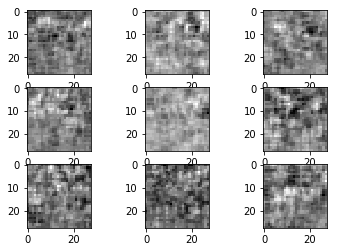

In [137]:
for step in range(100001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     print batch_x.shape
#     print batch_size
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)}))
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train

        
zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 0.111016  g-loss: 1.81128e-10 k_t: -2827.84629114 M_global: 0.166524
step: 1000  d-loss: 0.112057  g-loss: 1.68215e-10 k_t: -2827.79028235 M_global: 0.168085
step: 2000  d-loss: 0.110527  g-loss: 1.69127e-10 k_t: -2827.73423343 M_global: 0.165791
step: 3000  d-loss: 0.1078  g-loss: 1.66414e-10 k_t: -2827.67823242 M_global: 0.161701
step: 4000  d-loss: 0.113037  g-loss: 1.63028e-10 k_t: -2827.62222348 M_global: 0.169556
step: 5000  d-loss: 0.110803  g-loss: 1.53748e-10 k_t: -2827.56617348 M_global: 0.166205
step: 6000  d-loss: 0.110585  g-loss: 1.50288e-10 k_t: -2827.51015448 M_global: 0.165877
step: 7000  d-loss: 0.107581  g-loss: 1.49547e-10 k_t: -2827.45415397 M_global: 0.161371
step: 8000  d-loss: 0.113804  g-loss: 1.42718e-10 k_t: -2827.39812937 M_global: 0.170706
step: 9000  d-loss: 0.114012  g-loss: 1.36672e-10 k_t: -2827.34210413 M_global: 0.171018
step: 10000  d-loss: 0.11142  g-loss: 1.43035e-10 k_t: -2827.28607666 M_global: 0.16713
step: 11000  d-loss: 0.1058

step: 92000  d-loss: 0.113675  g-loss: 3.4348e-11 k_t: -2822.69223845 M_global: 0.170513
step: 93000  d-loss: 0.113963  g-loss: 3.42477e-11 k_t: -2822.63621147 M_global: 0.170944
step: 94000  d-loss: 0.107138  g-loss: 4.23127e-11 k_t: -2822.58020658 M_global: 0.160707
step: 95000  d-loss: 0.105435  g-loss: 3.42794e-11 k_t: -2822.5241732 M_global: 0.158152
step: 96000  d-loss: 0.112012  g-loss: 3.49212e-11 k_t: -2822.46814743 M_global: 0.168018
step: 97000  d-loss: 0.115796  g-loss: 3.39236e-11 k_t: -2822.41212413 M_global: 0.173694
step: 98000  d-loss: 0.108841  g-loss: 3.35073e-11 k_t: -2822.35612497 M_global: 0.163261
step: 99000  d-loss: 0.114157  g-loss: 3.14263e-11 k_t: -2822.30008672 M_global: 0.171235
step: 100000  d-loss: 0.110712  g-loss: 3.1462e-11 k_t: -2822.24406453 M_global: 0.166068


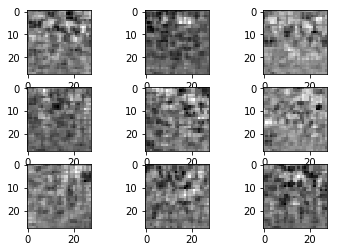

In [138]:
for step in range(100001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     print batch_x.shape
#     print batch_size
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    k_t = k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)}))
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train

        
zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')